# Ligand Selection and Preparation, Docking and Analysis

This notebook contains the code necessary to; prepare the ligands for docking, run docking in smina, and analyse the results of the docking.

In [1]:
# Ensure docking-env is activated as kernel.

# Import all libraries that are required.

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDistGeom
from rdkit.Chem.rdmolfiles import MolToPDBFile
import os
import pandas as pd
import numpy as np
from standardiser import standardise

DATAPATH = '../data'
RESULTSPATH = '../results'


## Ligand Selection, Validation and Standardisation

Ligand selection step involves;

- Identification of ligands (from generative model, DB's, etc) and extraction as smiles strings
- Standardisation - smiles-->mol, mol--> smiles, removal of any ligands that have no smiles
- Filtering of ligands (based on pharmacophore matching score, eos models, synthetic likelihood, etc)

Note on using Erilia 'find similar compounds' models - these return a .csv file with input smiles, then all similar smiles in one cell, comma separated. These can be separated by 'text to columns', and this gives the smiles in a row. Can then select all manually (shift), cut, paste and transpose. Then find " ' " and replace with nothing. Must add in an 'ID' column, can just have numbers (1-x), as this must be called to be used as filename when converting smiles->mols for 3D gen. Save.

In [2]:
# Ligand standardisation code here - smiles -> mol -> standard mol -> standard smiles

''' 
Convert .csv to dataframe for future actions

Convert smiles to molfile, convert to list

Generate list for standardised mols
    Standardise the mols, if this can't be done return a none value (np.nan)

Generate a list for std smiles
    If the above is not none (if the standardisation has worked) then convert from std mol -> smiles

Create df for the std_smiles

Get rid of none values (we can't use these anyway)

Get rid of smiles columns

Convert back to csv
'''

csv_file = os.path.join(DATAPATH, "cho_sim50", "cho_sim50.csv")

df=pd.read_csv(csv_file) 

mols = [Chem.MolFromSmiles(smi) for smi in df["SMILES"].tolist()]

std_mols = []

for mol in mols:
    if mol is not None:
        try:
            std_mol = standardise.run(mol)
        except:
            std_mol = np.nan
    else:
        std_mol = np.nan
    std_mols += [std_mol]

std_smiles = []

for std_mol in std_mols:
    if std_mol is not None:
        try: 
            std_smi = Chem.MolToSmiles(std_mol)
        except:
            std_smi=np.nan
    else:
        std_smi = np.nan
    std_smiles += [std_smi]

df["ST_SMILES"] = std_smiles

df=df[df["ST_SMILES"].notna()]

df.drop(columns = ["SMILES"], inplace=True)

df.to_csv('../data/cho_sim50/std_cho_sim50.csv', index=False)


## Ligand Preparation

- Conversion of smiles strings to 3D conformers using RDKIT 
- Protonation at a specific pH (7.4) and conversion to .pdbqt via obabel
- OR
- Protonation at a specific pH, conversion to .sdf and merging of all .sdf files into one .sdf file containing all ligands

In [3]:
std_csv_file = os.path.join(DATAPATH, "cho_sim50", "std_cho_sim50.csv")
pH = 7.4
sdf_folder = os.path.join(DATAPATH, "cho_sim50")


In [4]:
# The below takes a .csv file with smiles strings and converts them to a single .sdf file containing all smiles strings in protonated 3D format.

# Update doc string
def prepare_ligands_sdf(std_csv_file, pH, header_len=1, output_dir = sdf_folder, delim=',') -> list:

    """
    Takes a csv file of smiles, generates 3D coordinates,
    protonates for a specific pH, and outputs a pdbqt file 
    for each of the compounds therein. 

      
    csv_file_name (str): File path to a csv file containing the smiles input, among other information.
    
    header_len (int): num of rows to skip in the csv file.
    
    pH (float): pH that the compounds will be protonated at.
    
    output_dir (str): str appended to the produced file name so output files can be conveniently stored in an
                        output directory
    
    delim (str): delimeter used in the csv file

        
    returns: list of strs of the produced pdbqt file's paths.
    
    """
    
    out_sdfs = [] # Creates an empty list to fill.
    
    print(std_csv_file)
    
    with open(std_csv_file, 'r') as csv: 
        
        
        for entry in csv.readlines()[header_len:]:
            
            #Similarity, ID, SMILES = entry.split(delim)[:3]  # Note that this must be changed depending on the headings in the .csv file.

            ID, ST_SMILES = entry.split(delim)[:2]            
           
            # Convert smiles str to 3D coordinates
            mol = Chem.MolFromSmiles(ST_SMILES)
            mol = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol)
            
    
            # Ouput coords to pdb
            pdb_name = f"{output_dir}/{ID}.pdb"
            MolToPDBFile(mol, pdb_name)
            
#             print(pdb_name)
            # Protonate according to pH, convert to .sdf
            sdf_name = f"{output_dir}/{ID}.sdf"
            ! obabel {pdb_name} -pH {pH} -O {sdf_name}
            
            os.remove(pdb_name) # removes the .pdb files after obabel protonates and converts to .sdf
            
            out_sdfs.append(sdf_name)
#             print()
            
    return out_sdfs



def merge_sdfs(out_sdfs, merged_sdf):

    mols = []
    for s in out_sdfs:
        suppl = Chem.SDMolSupplier(s)
        for mol in suppl:
            mols += [mol]
        os.remove(s)

    with Chem.SDWriter(merged_sdf) as w:
        for mol in mols:
            w.write(mol)

def prepare_and_merge_ligands(std_csv_file,  pH, header_len=1, output_dir='', delim=','):
    ligands = prepare_ligands_sdf(std_csv_file,  pH, header_len, output_dir, delim)
    merge_sdfs(ligands, output_dir+"/cho_sim50_merged.sdf")
        

In [ ]:
prepare_and_merge_ligands(std_csv_file, pH, output_dir=sdf_folder)



In [58]:
std_csv_file = os.path.join(DATAPATH, "cho_sim50", "std_cho_sim50.csv")

In [6]:
# The below is the same as the above, with **multiple conformers** generated.

# Update doc string
def prepare_multiple_conf_ligands_sdf(csv_file,  pH, header_len=1, output_dir='', delim=',') -> list:

    """
    Takes a csv file of smiles, generates 3D coordinates,
    protonates for a specific pH, and outputs a pdbqt file 
    for each of the compounds therein. 

      
    csv_file_name (str): File path to a csv file containing the smiles input, among other information.
    
    header_len (int): num of rows to skip in the csv file.
    
    pH (float): pH that the compounds will be protonated at.
    
    output_dir (str): str appended to the produced file name so output files can be conveniently stored in an
                        output directory
    
    delim (str): delimeter used in the csv file

        
    returns: list of strs of the produced pdbqt file's paths.
    
    """
    
    out_sdfs = [] # Creates an empty list to fill.
    
    print(std_csv_file)
    
    with open(std_csv_file, 'r') as csv: 
        
        
        for entry in csv.readlines()[header_len:]:
            
            ID, SMILES = entry.split(delim)[:3]  # Note that this must be changed depending on the headings in the .csv file.
            
            # Convert smiles str to 3D coordinates
            mol = Chem.MolFromSmiles(SMILES)
            mol = Chem.AddHs(mol)
            Chem.rdDistGeom.EmbedMultipleConfs(mol, numConfs=5, pruneRmsThresh=1.0)
            
    
            # Ouput coords to pdb
            pdb_name = f"{output_dir}/{ID}.pdb"
            MolToPDBFile(mol, pdb_name)
            
#             print(pdb_name)
            # Protonate according to pH, convert to .sdf
            sdf_name = f"{output_dir}/{ID}.sdf"
            ! obabel {pdb_name} -pH {pH} -O {sdf_name}
            
            os.remove(pdb_name) # removes the .pdb files after obabel protonates and converts to .sdf
            
            out_sdfs.append(sdf_name)
#             print()
            
    return out_sdfs



def merge_sdfs(out_sdfs, merged_sdf):

    mols = []
    for out_sdf in out_sdfs:
        suppl = Chem.SDMolSupplier(out_sdf)
        for mol in suppl:
            mols += [mol]
        os.remove(out_sdf)

    with Chem.SDWriter(merged_sdf) as w:
        for mol in mols:
            w.write(mol)

def prepare_and_merge_multipleconf_ligands(csv_file,  pH, header_len=1, output_dir='', delim=','):
    ligands = prepare_multiple_conf_ligands_sdf(csv_file,  pH, header_len, output_dir, delim)
    merge_sdfs(ligands, output_dir+"/cho_sim50_nconf5_merged.sdf")
        

In [ ]:
prepare_and_merge_multipleconf_ligands(std_csv_file, pH, output_dir=sdf_folder)

# Docking with smina

- Receptor is prepped manually for this project using ADTools (waters removed, polar hydrogens added, Gasteiger charges added, saved as .pdbqt file)
- Flexible side chains identified (not done below...)
- Ligand (CHO) can be readded as hetatm/different chain for autobox generation
- smina run (search space defined on command line) and outputs saved

In [ ]:
# The below is smina, run using the single .sdf file with all ligands, nconf=1. 

receptor = '../data/protein/pabb_model1.pdbqt'  # Receptor
ligands = '../data/cho_sim50/cho_sim50_merged.sdf'  # Ligand
log = '../results/cho_sim50/cho_sim50_log.txt' # log file
path_to_results = '../results/cho_sim50/cho_sim50_output.sdf' 
path_to_smina = '../src/smina.static'

cmd = path_to_smina  + " -r " + receptor + " -l " + ligands + " -o " + path_to_results + " --log " + log + " --seed 42 " + " --center_x 74 " + " --center_y 47 " + " --center_z 57 " + " --size_x 20 " + " --size_y 20 " + " --size_z 27 " + " --exhaustiveness 20 " + " --num_modes 1 " + " --addH off "

os.system(cmd)

## Analysis

Here, the top poses will be selected and analysed.

- See SDSorter, with 'reduceconf' and 'nbestx'
- Also see 'sminalog_analysis.py'

In [ ]:
mypath = os.path.join(RESULTSPATH, "cho_sim50")
logfile = os.path.join(mypath, 'cho_sim50_log.txt')
affinities = os.path.join(mypath, 'affinities.csv')
affinities_header = os.path.join(mypath, 'affinities_header.csv')
std_csv_file = os.path.join(DATAPATH, "cho_sim50", "std_cho_sim50.csv")
affinities_and_smiles = os.path.join(mypath, 'affinities_with_stdsmiles.csv')                                

with open(logfile, "r") as f:
    i = 0;
    for line in f:
        if '-+' in line:
            nextline = next(f)
            i = i + 1

            nextlinearray  = nextline.split()                       #splitting the first row in different values
            bind_aff = nextlinearray[1]                             #getting the binding affinity of first pose

            with open(affinities, "a") as myfile:
                 print(bind_aff, end='\n', file=myfile)
    

df = pd.read_csv(affinities, names = ['AFFINITY'])

headerList = ['AFFINITY']
df.to_csv(affinities_header, header=headerList, index=False)
df = pd.read_csv(affinities_header)

os.remove(affinities)

df1 = pd.read_csv(std_csv_file)
df2 = pd.read_csv(affinities_header)

merged = pd.concat([df1, df2], axis="columns")
merged.drop(columns = ["ID"], inplace=True) # this removes the ID line, so output is smiles and affininty only... could keep.

merged.to_csv(affinities_and_smiles, index=False)
print(merged)

os.remove(affinities_header)




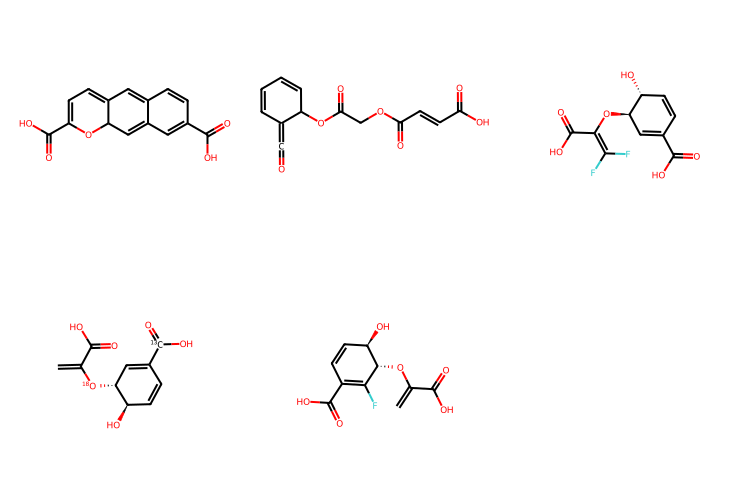

In [23]:
# Double check the lowest scoring compound manually (low scoring is better).

# The below are the top 5 binders from the cho_sim50 search - .csv output taken and 

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

a = Chem.MolFromSmiles('O=C(O)C1=CC=C2C=c3ccc(C(=O)O)cc3=CC2O1')
b = Chem.MolFromSmiles('O=C=C1C=CC=CC1OC(=O)COC(=O)/C=C/C(=O)O')
c = Chem.MolFromSmiles('O=C(O)C1=C[C@@H](OC(C(=O)O)=C(F)F)[C@H](O)C=C1')
d = Chem.MolFromSmiles('C=C([18O][C@@H]1C=C([13C](=O)O)C=C[C@H]1O)C(=O)O')
e = Chem.MolFromSmiles('C=C(O[C@@H]1C(F)=C(C(=O)O)C=C[C@H]1O)C(=O)O')

Draw.MolsToGridImage((a,b,c,d,e), subImgSize=(250,250))
